In [49]:
import pandas as pd
import numpy as np
import plotly.graph_objects as plgo
from plotly.subplots import make_subplots
import seaborn as sns


In [2]:
START_DATE = pd.to_datetime('2023-10-27')
END_DATE = pd.to_datetime('2023-11-24')

In [4]:
brent_df = pd.read_csv('oil_futures_data.csv',
                       usecols=['Date', 'Close'],
                       parse_dates=['Date'],
                       dtype={'Close': float})

brent_df = brent_df[(brent_df['Date'] >= START_DATE) & (brent_df['Date'] <= END_DATE)]
brent_df = brent_df.iloc[::-1].reset_index(drop=True)
brent_df.rename(columns={'Close': 'Value'}, inplace=True)
brent_df.head()

,Date,Value
0,2023-10-27,89.20
1,2023-10-30,86.35
2,2023-10-31,85.02
3,2023-11-01,84.63
4,2023-11-02,86.85


In [5]:
wti_df = pd.read_csv('/Users/shrek/Downloads/Datathon Data/all_commodities.csv',
                     usecols=['Date_Time','Value','Commodity'],
                     parse_dates=['Date_Time'],
                     dtype={'Value': float, 'Commodity': str})

wti_df = wti_df[(wti_df['Commodity']=='West Texas Intermediary Crude Oil') & (wti_df['Date_Time'] >= START_DATE) & (wti_df['Date_Time'] <= END_DATE)]
wti_df = wti_df.iloc[::-1].reset_index(drop=True)
wti_df.drop(columns=['Commodity'], inplace=True)
wti_df.rename(columns={'Date_Time': 'Date'}, inplace=True)
wti_df.head()

,Date,Value
0,2023-10-27,86.04
1,2023-10-30,83.03
2,2023-10-31,81.64
3,2023-11-01,81.05
4,2023-11-02,83.04


In [6]:
henry_df = pd.read_csv('/Users/shrek/Downloads/Datathon Data/all_commodities.csv',
                       usecols=['Date_Time','Value','Commodity'],
                       parse_dates=['Date_Time'],
                       dtype={'Value': float, 'Commodity': str})

henry_df = henry_df[(henry_df['Commodity']=='Henry Hub Natural Gas Spot Price') & (henry_df['Date_Time'] >= START_DATE) & (henry_df['Date_Time'] <= END_DATE)]
henry_df = henry_df.iloc[::-1].reset_index(drop=True)
henry_df.drop(columns=['Commodity'], inplace=True)
henry_df.rename(columns={'Date_Time': 'Date'}, inplace=True)
henry_df.head()

,Date,Value
0,2023-10-27,3.24
1,2023-10-30,3.17
2,2023-10-31,3.34
3,2023-11-01,3.19
4,2023-11-02,3.12


In [7]:
for df in [brent_df, henry_df, wti_df]:
    df['Value'].fillna(method='bfill', inplace=True)
    df['Value_EMA'] = df['Value'].ewm(span=5, adjust=False).mean()

In [8]:
df_probs = pd.read_excel('manual_data.xlsx', header=3)
df_probs['date'] = df_probs['date'].map(lambda date: date - pd.DateOffset(years=1)).ffill()
df_probs_grouped = df_probs.groupby('date').mean().reset_index()
df_probs_grouped.drop(columns=['hour'], inplace=True)
df_probs_grouped['value'] /= 100
df_probs_grouped.rename(columns={'date': 'day', 'value': 'prediction'}, inplace=True)
df_probs_grouped = df_probs_grouped[(df_probs_grouped['day'].dt.weekday < 5) & (df_probs_grouped['day'] >= START_DATE) & (df_probs_grouped['day'] <= END_DATE)]
df_probs_grouped['prediction_EMA'] = df_probs_grouped['prediction'].ewm(span=5, adjust=False).mean()
df_probs_grouped.head()

,day,prediction,prediction_EMA
0,2023-10-27,0.21200,0.212000
3,2023-10-30,0.19375,0.205917
4,2023-10-31,0.15500,0.188944
5,2023-11-01,0.10125,0.159713
6,2023-11-02,0.10625,0.141892


In [9]:
fig = plgo.Figure()
fig.add_trace(plgo.Scatter(x=df_probs_grouped['day'], y=df_probs_grouped['prediction'], mode='lines+markers', name='PolyMarket Prediction %'))
fig.add_trace(plgo.Scatter(x=df_probs_grouped['day'], y=df_probs_grouped['prediction_EMA'], mode='lines+markers', name='PolyMarket Prediction % EMA'))

fig.update_yaxes(range=[0, 1])
fig.update_layout(title='PolyMarket Prediction of Hamas Ceasefire Before November 30th 2023')
fig.show()

In [10]:
fig = plgo.Figure()
normalize = lambda series: (series - series.min()) / (series.max() - series.min())
for (df,name) in [(brent_df, 'Brent Crude'), (henry_df, 'Henry Hub'), (wti_df, 'WTI')]:
    fig.add_trace(plgo.Scatter(x=df['Date'], y=normalize(df['Value']), mode='lines+markers', name=name))
    fig.add_trace(plgo.Scatter(x=df['Date'], y=normalize(df['Value_EMA']), mode='lines+markers', name=name + ' EMA'))

fig.update_layout(title='Normalized Oil and Natural Gas Prices')
fig.show()

In [11]:
fig = plgo.Figure()
for (df,name) in [(brent_df, 'Brent Crude'), (henry_df, 'Henry Hub'), (wti_df, 'WTI')]:
    fig.add_trace(plgo.Scatter(x=df['Date'], y=normalize(df['Value_EMA']), mode='lines+markers', name=name + ' EMA'))

fig.add_trace(plgo.Scatter(x=df_probs_grouped['day'], y=normalize(df_probs_grouped['prediction_EMA']), mode='lines+markers', name='Manifold Prediction % EMA'))
fig.update_layout(title='Normalized Oil and Natural Gas EMA Prices with PolyMarket Prediction % EMA')
fig.show()

In [12]:
for (df, name) in [(brent_df, 'Brent Crude'), (wti_df, 'WTI'), (henry_df, 'Henry Hub')]:
    print(f'{name} EMA correlation coefficient with PolyMarket Prediction % EMA: {np.corrcoef(df["Value_EMA"], df_probs_grouped["prediction_EMA"])[0, 1]}')

Brent Crude EMA correlation coefficient with PolyMarket Prediction % EMA: -0.4708552071353263
WTI EMA correlation coefficient with PolyMarket Prediction % EMA: -0.587828188873307
Henry Hub EMA correlation coefficient with PolyMarket Prediction % EMA: -0.3317747300454457


Visualization

In [61]:
brent_df['pctchange'] = brent_df['Value_EMA'].pct_change().dropna()
wti_df['pctchange'] = wti_df['Value_EMA'].pct_change().dropna()
henry_df['pctchange'] = henry_df['Value_EMA'].pct_change().dropna()
df_probs_grouped['pctchange'] = df_probs_grouped['prediction_EMA'].pct_change().dropna()

In [69]:
brent_df['normalized'] = (brent_df['Value_EMA'] - np.mean(brent_df['Value_EMA'])) / np.std(brent_df['Value_EMA'])
wti_df['normalized'] = (wti_df['Value_EMA'] - np.mean(wti_df['Value_EMA'])) / np.std(wti_df['Value_EMA'])
henry_df['normalized'] = (henry_df['Value_EMA'] - np.mean(henry_df['Value_EMA'])) / np.std(henry_df['Value_EMA'])
df_probs_grouped['normalized'] = (df_probs_grouped['prediction_EMA'] - np.mean(df_probs_grouped['prediction_EMA'])) / np.std(df_probs_grouped['prediction_EMA'])

fig = make_subplots(rows=1, cols=4)

fig.add_trace(plgo.Violin(y=brent_df['pctchange'], name='Brent Crude Front Month Future Prices', box_visible=True, meanline_visible=True), row=1, col=1)
fig.add_trace(plgo.Violin(y=wti_df['pctchange'], name='West Texas Intermediary Crude Oil', box_visible=True, meanline_visible=True), row=1, col=2)
fig.add_trace(plgo.Violin(y=henry_df['pctchange'], name='Henry Hub Natural Gas Spot Price', box_visible=True, meanline_visible=True), row=1, col=3)
fig.add_trace(plgo.Violin(y=df_probs_grouped['pctchange'], name='Polymarket Prediction Values', box_visible=True, meanline_visible=True), row=1, col=4)



#title='Violin Plot of Normalized Day-to-Day Values'
fig.update_layout(yaxis_title='Pct Change Values')
fig.show()


In [63]:
print(brent_df['pctchange'].describe())
print("-"*50)
print(wti_df['pctchange'].describe())
print("-"*50)
print(henry_df['pctchange'].describe())
print("-"*50)
print(df_probs_grouped['pctchange'].describe())

count    20.000000
mean     -0.004646
std       0.007894
min      -0.018964
25%      -0.010736
50%      -0.003461
75%       0.001834
max       0.007799
Name: pctchange, dtype: float64
--------------------------------------------------
count    20.000000
mean     -0.006210
std       0.008123
min      -0.020119
25%      -0.011632
50%      -0.006765
75%       0.000626
max       0.006692
Name: pctchange, dtype: float64
--------------------------------------------------
count    20.000000
mean     -0.008572
std       0.033439
min      -0.110427
25%      -0.019789
50%      -0.001643
75%       0.010498
max       0.030344
Name: pctchange, dtype: float64
--------------------------------------------------
count    20.000000
mean      0.076211
std       0.143840
min      -0.154709
25%      -0.030320
50%       0.068504
75%       0.154824
max       0.398030
Name: pctchange, dtype: float64


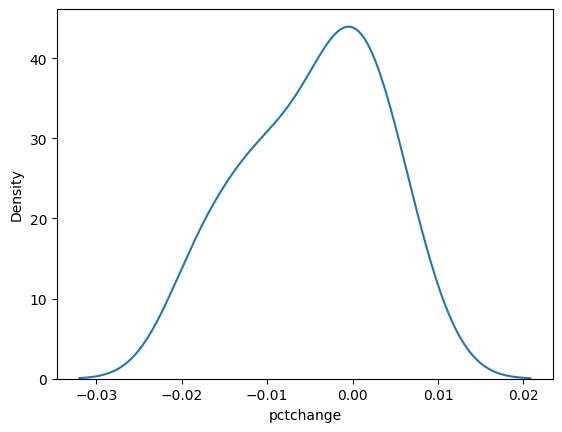

In [64]:
sns_kde_brent = sns.kdeplot(brent_df['pctchange'], label='Brent')
brent_kde_values = sns_kde_brent.get_lines()[0].get_ydata()
brent_x_values = sns_kde_brent.get_lines()[0].get_xdata()

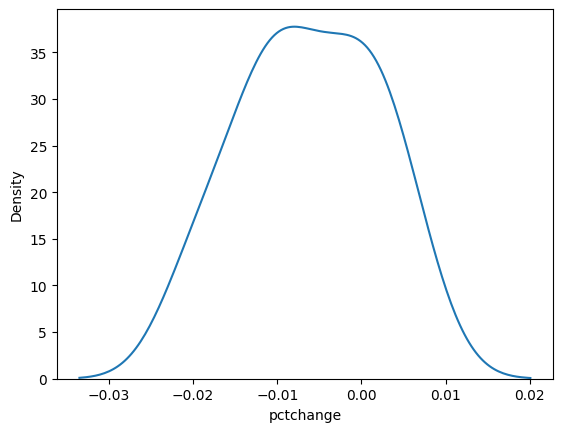

In [65]:
sns_kde_wti = sns.kdeplot(wti_df['pctchange'], label='WTI')
wti_kde_values = sns_kde_wti.get_lines()[0].get_ydata()
wti_x_values = sns_kde_wti.get_lines()[0].get_xdata()

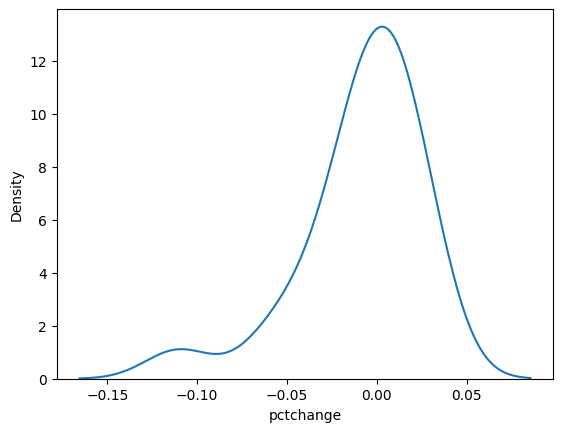

In [66]:
sns_kde_henry = sns.kdeplot(henry_df['pctchange'], label='Henry')
henry_kde_values = sns_kde_henry.get_lines()[0].get_ydata()
henry_x_values = sns_kde_henry.get_lines()[0].get_xdata()

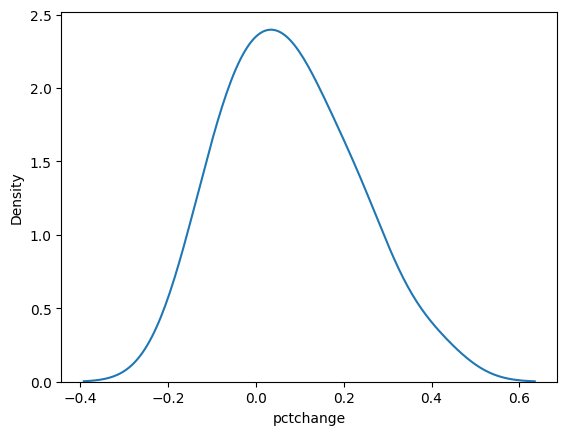

In [67]:
sns_kde_probs = sns.kdeplot(df_probs_grouped['pctchange'], label='Prediction Market')
probs_kde_values = sns_kde_probs.get_lines()[0].get_ydata()
probs_x_values = sns_kde_probs.get_lines()[0].get_xdata()

In [68]:

# Create Plotly figure
fig = plgo.Figure()

# Add KDE line
fig.add_trace(plgo.Scatter(x=brent_x_values, y=brent_kde_values, mode='lines', name='Brent'))
fig.add_trace(plgo.Scatter(x=wti_x_values, y=wti_kde_values, mode='lines', name='WTI'))
fig.add_trace(plgo.Scatter(x=henry_x_values, y=henry_kde_values, mode='lines', name='Henry'))
fig.add_trace(plgo.Scatter(x=probs_x_values, y=probs_kde_values, mode='lines', name='Prediction Market'))

# Update layout
#title='Kernel Density Estimate (KDE) of Commodities and Prediction Market Values',
fig.update_layout(xaxis=dict(title='pct change Value'),
                  yaxis=dict(title='Density'),
                  showlegend=True)

# Show plot
fig.show()

In [70]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y


x_brent, y_brent = ecdf(brent_df['pctchange'])
x_wti, y_wti = ecdf(wti_df['pctchange'])
x_henry, y_henry = ecdf(henry_df['pctchange'])
x_probs, y_probs = ecdf(df_probs_grouped['pctchange'])

fig = plgo.Figure()

# Add KDE line
fig.add_trace(plgo.Scatter(x=x_brent, y=y_brent, mode='lines', name='Brent'))
fig.add_trace(plgo.Scatter(x=x_wti, y=y_wti, mode='lines', name='WTI'))
fig.add_trace(plgo.Scatter(x=x_henry, y=y_henry, mode='lines', name='Henry'))
fig.add_trace(plgo.Scatter(x=x_probs, y=y_probs, mode='lines', name='Prediction Market'))

# Update layout
#title='ECDF of Commodities and Prediction Market Values',
fig.update_layout(xaxis=dict(title='Percent Change Value'),
                  yaxis=dict(title='Density'),
                  showlegend=True)

# Show plot
fig.show()

In [74]:
from scipy.stats import ks_2samp

# Perform KS test
 
print(ks_2samp(brent_df['pctchange'], df_probs_grouped['pctchange']))
print(ks_2samp(wti_df['pctchange'], df_probs_grouped['pctchange']))
print(ks_2samp(henry_df['pctchange'], df_probs_grouped['pctchange']))
# print(ks_2samp(wti_df['pctchange'], brent_df['pctchange']))

KstestResult(statistic=0.5714285714285714, pvalue=0.0016567962353134283, statistic_location=0.005693477306118577, statistic_sign=1)
KstestResult(statistic=0.5714285714285714, pvalue=0.0016567962353134283, statistic_location=0.005512565533973612, statistic_sign=1)
KstestResult(statistic=0.5714285714285714, pvalue=0.0016567962353134283, statistic_location=0.030344429305125376, statistic_sign=1)
